## Protocolo Descentralizado

No protocolo descentralizado, o preenchimento das tabelas de repasse dos ``Hosts`` é feito sem o uso de um controlador.

In [1]:
from quantumnet.components import Network, Host
import networkx as nx

Criando uma versão extendida do Host. Essa versão diferencia-se pelo método adicional ``exchange_routes()`` que realiza a troca de rotas de forma descentralizada.

In [2]:
class DescHost(Host):
    def __init__(self, host_id):
        super().__init__(host_id)
        #self.host_id = host_id
    
    def exchange_routes(self, neighbor):
        updated = False
        neighbor_routing_table = neighbor.routing_table

        print(f"\nNode {self.host_id} exchanging routes with Neighbor {neighbor.host_id}")
        print(f"Current Routing Table for Node {self.host_id}: {self.routing_table}")
        print(f"Neighbor {neighbor.host_id} Routing Table: {neighbor_routing_table}")

        for dest, neighbor_path in neighbor_routing_table.items():
            # If we don't know the destination or found a shorter path through the neighbor
            if dest not in self.routing_table or len(neighbor_path) + 1 < len(self.routing_table[dest]):
                old_route = self.routing_table.get(dest, "None")
                self.routing_table[dest] = [self.host_id] + neighbor_path  # Prepend own ID to the path
                updated = True
                print(f"Node {self.host_id} updated route to {dest}: {old_route} -> {self.routing_table[dest]}")

        return updated

A função a seguir somente cria uma topologia pronta, é um método da classe ``Network`` também.

In [3]:
def set_ready_topology(rede, topology_name: str, *args: int) -> str:
        """
        Cria um grafo com uma das topologias prontas para serem utilizadas. 
        São elas: Grade, Linha, Anel. Os nós são numerados de 0 a n-1, onde n é o número de nós.

        Args: 
            topology_name (str): Nome da topologia a ser utilizada.
            **args (int): Argumentos para a topologia. Geralmente, o número de hosts.
        
        """
        # Nomeia a topologia da rede
        rede._topology = topology_name
    
        # Cria o grafo da topologia escolhida
        if topology_name == 'Grade':
            if len(args) != 2:
                raise Exception('Para a topologia Grade, são necessários dois argumentos.')
            rede._graph = nx.grid_2d_graph(*args)
        elif topology_name == 'Linha':
            if len(args) != 1:
                raise Exception('Para a topologia Linha, é necessário um argumento.')
            rede._graph = nx.path_graph(*args)
        elif topology_name == 'Anel':
            if len(args) != 1:
                raise Exception('Para a topologia Anel, é necessário um argumento.')
            rede._graph = nx.cycle_graph(*args)

        # Converte os labels dos nós para inteiros
        rede._graph = nx.convert_node_labels_to_integers(rede._graph)

        # Cria os hosts e adiciona ao dicionário de hosts
        for node in rede._graph.nodes():
            rede._hosts[node] = DescHost(node)
        rede.start_hosts()
        rede.start_channels()
        rede.start_eprs()

Protocolo de troca de rotas descentralizado para os nós da rede. 

In [4]:
def qbgp(rede, max_iterations=20):
    """
    Run the Quantum BGP algorithm on the given nodes.

    Args:
        nodes (list): List of nodes in the network.
        max_iterations (int): Maximum number of iterations to run the algorithm.
    """
    iteration = 0
    updated = True

    while updated and iteration < max_iterations:
        print(f"\n===================== Iteration {iteration+1} =====================")
        updated = False
        # Go through each node and let it exchange routes with its neighbors
        for host_id, host in rede.hosts.items():
            for neighbor_id in rede.graph.neighbors(host_id):
                neighbor_node = rede.get_host(neighbor_id)
                if host.exchange_routes(neighbor_node):
                    updated = True  # If any node updates its table, we continue the process
        iteration += 1

A rede é iniciada:

Hosts inicializados
Canais inicializados
Pares EPRs adicionados


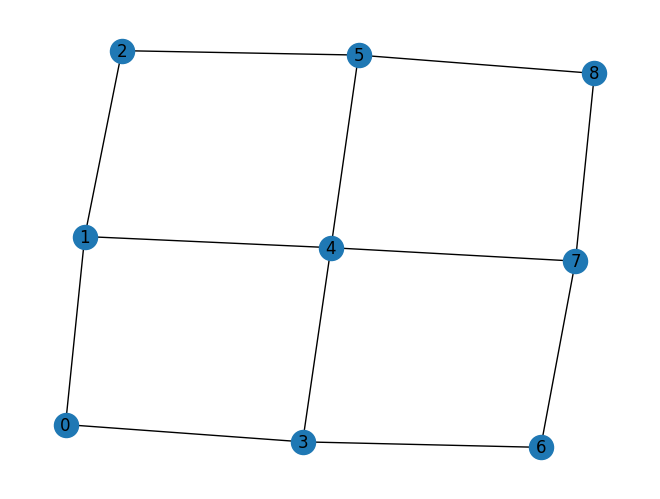

In [5]:
rede = Network()
set_ready_topology(rede, "Grade", 3, 3)
rede.draw()

A tabela de roteamento dos nós contém apenas o caminho para os próprios nós. Ou seja, não contém nenhuma informação sobre as rotas ainda.

In [6]:
for host_id in rede.hosts:
    print(rede.get_host(host_id).info())

{'host_id': 0, 'memory': 10, 'routing_table': {0: [0]}}
{'host_id': 1, 'memory': 10, 'routing_table': {1: [1]}}
{'host_id': 2, 'memory': 10, 'routing_table': {2: [2]}}
{'host_id': 3, 'memory': 10, 'routing_table': {3: [3]}}
{'host_id': 4, 'memory': 10, 'routing_table': {4: [4]}}
{'host_id': 5, 'memory': 10, 'routing_table': {5: [5]}}
{'host_id': 6, 'memory': 10, 'routing_table': {6: [6]}}
{'host_id': 7, 'memory': 10, 'routing_table': {7: [7]}}
{'host_id': 8, 'memory': 10, 'routing_table': {8: [8]}}


Cada nó da rede se comunica com os outros nós da rede trocando informações. A cada iteração, os nós trocam informações sobre seus caminhos com seus vizinhos. Se um nó encontra um caminho mais curto para algum destino através de um vizinho, ele atualiza sua tabela de roteamento. Isso continua até que nenhuma tabela seja mais atualizada ou o número máximo de iterações seja atingido.

In [7]:
qbgp(rede)


===================== Iteration 1 =====================

Node 0 exchanging routes with Neighbor 3
Current Routing Table for Node 0: {0: [0]}
Neighbor 3 Routing Table: {3: [3]}
Node 0 updated route to 3: None -> [0, 3]

Node 0 exchanging routes with Neighbor 1
Current Routing Table for Node 0: {0: [0], 3: [0, 3]}
Neighbor 1 Routing Table: {1: [1]}
Node 0 updated route to 1: None -> [0, 1]

Node 1 exchanging routes with Neighbor 0
Current Routing Table for Node 1: {1: [1]}
Neighbor 0 Routing Table: {0: [0], 3: [0, 3], 1: [0, 1]}
Node 1 updated route to 0: None -> [1, 0]
Node 1 updated route to 3: None -> [1, 0, 3]

Node 1 exchanging routes with Neighbor 4
Current Routing Table for Node 1: {1: [1], 0: [1, 0], 3: [1, 0, 3]}
Neighbor 4 Routing Table: {4: [4]}
Node 1 updated route to 4: None -> [1, 4]

Node 1 exchanging routes with Neighbor 2
Current Routing Table for Node 1: {1: [1], 0: [1, 0], 3: [1, 0, 3], 4: [1, 4]}
Neighbor 2 Routing Table: {2: [2]}
Node 1 updated route to 2: None -> [

In [8]:
for host_id in rede.hosts:
    print(rede.get_host(host_id).info())

{'host_id': 0, 'memory': 10, 'routing_table': {0: [0], 3: [0, 3], 1: [0, 1], 6: [0, 3, 6], 4: [0, 3, 4], 2: [0, 1, 2], 7: [0, 3, 6, 7], 5: [0, 3, 4, 5], 8: [0, 3, 6, 7, 8]}}
{'host_id': 1, 'memory': 10, 'routing_table': {1: [1], 0: [1, 0], 3: [1, 0, 3], 4: [1, 4], 2: [1, 2], 6: [1, 0, 3, 6], 7: [1, 4, 7], 5: [1, 4, 5], 8: [1, 4, 7, 8]}}
{'host_id': 2, 'memory': 10, 'routing_table': {2: [2], 1: [2, 1], 0: [2, 1, 0], 3: [2, 1, 0, 3], 4: [2, 1, 4], 5: [2, 5], 6: [2, 1, 0, 3, 6], 7: [2, 1, 4, 7], 8: [2, 5, 8]}}
{'host_id': 3, 'memory': 10, 'routing_table': {3: [3], 0: [3, 0], 1: [3, 0, 1], 6: [3, 6], 4: [3, 4], 2: [3, 0, 1, 2], 7: [3, 6, 7], 5: [3, 4, 5], 8: [3, 6, 7, 8]}}
{'host_id': 4, 'memory': 10, 'routing_table': {4: [4], 1: [4, 1], 0: [4, 1, 0], 3: [4, 3], 2: [4, 1, 2], 6: [4, 3, 6], 7: [4, 7], 5: [4, 5], 8: [4, 7, 8]}}
{'host_id': 5, 'memory': 10, 'routing_table': {5: [5], 2: [5, 2], 1: [5, 2, 1], 0: [5, 2, 1, 0], 3: [5, 4, 3], 4: [5, 4], 6: [5, 4, 3, 6], 7: [5, 4, 7], 8: [5, 8]}}
{